In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jul 11 10:27:06 2018

@author: sjangra
"""
import numpy as np
import scipy.io       # To import data from .mat file
import matplotlib.pyplot as plt
import degradation_functions as df
import pandas as pd
import csvtool
import matplotlib as mpl
from operator import add
%matplotlib inline

In [5]:
#%% Importing data
# Loading files
cal_params = pd.read_csv('../data/cal_params_fitted.csv')
highT_param = pd.read_csv('../data/eva2_20180717/Data fitting/highT_parameters_newcal.csv')
dirc = '../data/eva2_20180717/20180615 cycle data part1/20180615_45oC'
file_name = 'HA212_00109__1-11-4-P73B__45oC__Cby3__2.75-4.20__20180615171320'
data = pd.read_csv(dirc + '/' + file_name + '.csv')
data_exp = pd.read_csv(dirc + '/' + file_name + '__extradata'+ '.csv')

In [6]:
# Calculating starting index
cycle_index = data['Cycle Index'].values
start_ind = np.where(cycle_index == 10)
start_ind = start_ind[0]
print('Starting index is: ',start_ind[0]-2)
data = data[start_ind[0]-2:]
data_exp = data_exp[10-1:]

# allocating data
I = data['Current [A]']
t = data['Time [hr]']
volt = data['Voltage [V]']
temp = 273.15 + np.mean([data['T2 [oC]'],data['T3 [oC]'],data['T3 [oC]']],axis=0)
cap_step = data['Step Capacity [Ah]'].values
step_index = data['Step Index'].values
cycle_index = data['Cycle Index'].values
dis_cap_exp = data_exp['Discharge Capacity [Ah]'].values

Starting index is:  8061


In [ ]:
# %% Writing data to csv
# csv_dirc = '../data/eva2_20180717/Data fitting/'
csv_dirc = '../data/cycle_data_export/'
csv_expdata_path = csv_dirc + file_name + '_expdata.csv'
csv_caploss_path = csv_dirc + file_name + '_caploss.csv'
I = np.ravel(I)
temp = np.ravel(temp)
t = np.ravel(t)
csvtool.dicttocsv(['I', 'SOC','Charge_thr','Tot_thr','Temp'], \
                 {'I':I, 'SOC':SOC,'Charge_thr' : charge_thr,'Tot_thr' : tot_thr, \
                  'Temp' : temp, 'Time [Hr]':t,'cycle_index':cycle_index }, csv_expdata_path)
csvtool.dicttocsv(['Qtot per cycle', 'Cap Loss'], {'Qtot per cycle':Q_tot_percycle, 'Cap Loss':cap_loss_exp}, csv_caploss_path)

cle = [float(str(cl)) for cl in cap_loss_exp]
qtc = [float(str(qt)) for qt in Q_tot_percycle]
arrT = [qtc, cle]
csv_data = np.array(arrT).T
csv_data = np.array(csv_data)
with open(csv_path, 'wb') as f:
   np.savetxt(f, csv_data, delimiter = ',', fmt='%.8f')

In [7]:
# converting 1d array to 2d array for consistency
t = t[np.newaxis,:]
temp = temp[np.newaxis,:]
I = I[np.newaxis,:]

#%% Defining parameters
F = 96485;  # Faraday's constant
k_cal_ref = float(cal_params['k_cal_ref'])
k_cyc_highT_ref = float(highT_param['K_cyc_ref_highT'])
k_cyc_lowT_ref = 3.01e-4
k_cyc_lowT_highSOC_ref = 2.03e-6
Ea_cal = float(cal_params['Ea_cal'])
Ea_cyc_highT = float(highT_param['Ea_highT'])
Ea_cyc_lowT = -5.55e4
Ea_cyc_lowT_highSOC = -2.33e5
beta_lowT = 2.64
beta_lowT_highSOC = 7.84
SOC_ref = 0.82
#C0 = 73
alpha = float(cal_params['alpha'])
k0 = float(cal_params['k0'])
Ich_ref = 77

#%% Initialization
K_cal = np.zeros((np.size(temp,0),np.size(t,1)))
K_cyc_highT = np.zeros((np.size(temp,0),np.size(t,1)))
K_cyc_lowT = np.zeros((np.size(temp,0),np.size(t,1)))
K_cyc_lowT_highSOC = np.zeros((np.size(temp,0),np.size(t,1)))
s_cyc_lowT_temp = np.zeros((np.size(temp,0),np.size(t,1)))
s_cyc_lowT_highSOC_temp = np.zeros((np.size(temp,0),np.size(t,1)))
Q_cal = np.zeros((np.size(temp,0),np.size(t,1)))
Q_cyc = np.zeros((np.size(temp,0),np.size(t,1)))
Q_tot = np.zeros((np.size(temp,0),np.size(t,1)))
Q_cyc_highT = np.zeros((np.size(temp,0),np.size(t,1)))
Q_cyc_lowT = np.zeros((np.size(temp,0),np.size(t,1)))
Q_cyc_lowT_highSOC = np.zeros((np.size(temp,0),np.size(t,1)))
s_cyc_lowT_cur = np.zeros((np.size(temp,0),np.size(t,1)))
s_cyc_lowT_highSOC_cur = np.zeros((np.size(temp,0),np.size(t,1)))
s_cal_soc = np.zeros((np.size(temp,0),np.size(t,1)))
SOC  = np.zeros(np.size(t,1))
charge_thr = np.zeros(np.size(t,1))
tot_thr = np.zeros(np.size(t,1))
charge = np.zeros(np.size(t,1))
cap = np.zeros(np.size(t,1))
SOC_step= np.zeros(np.size(t,1))
step_cap_diff= np.zeros(np.size(t,1))
cap_step_temp = np.zeros(np.size(t,1))
SOC[0] = 0.0
SOC_step[0] = SOC[0] 
cap[:] = 77
SOC_corr_count = 0
index = 0
corr_inds = []
Q_cyc_highT_percycle =[]
Q_cyc_lowT_percycle =[]
Q_cyc_lowT_highSOC_percycle =[]
Q_cal_percycle =[]

#%% Charge calculation through current
# Makes step cap difference equal to zero when the current is zero. Also makes the step cap
# value equal to zero for rest periods only and not for all I = 0

for i in range(1,np.size(t,1)):
    if I[0,i]==0:
        step_cap_diff[i] = 0
        if step_index[i]!= step_index[i-1]:
            cap_step_temp[i:] = 0   # temporary variable for step capacity
    else:
        cap_step_temp[i:] = cap_step[i:]
        step_cap_diff[i] = np.sign(I[0,i])*(cap_step_temp[i] - cap_step_temp[i-1])
tot_thr = np.cumsum(np.abs(step_cap_diff))    
pos_steps = np.zeros_like(step_cap_diff)
pos_steps[step_cap_diff > 0.] = step_cap_diff[step_cap_diff > 0.]
charge_thr = np.cumsum(pos_steps)
 
#%% Experimental capacity loss
cap_loss_exp = (dis_cap_exp[0] - dis_cap_exp)/dis_cap_exp[0]*100
cap_loss_exp = np.insert(cap_loss_exp,0,0)      
#%% Capacity loss calculation
j = 1
for i in range(0,np.size(temp,0)):
    while j< np.size(t,1):
                
        # New capacity
#        cap[j] = cap[0] - Q_tot[i,j-1]*cap[0]
        
         # SOC_step calculation using step capacity with correction
        if step_index[j]!= step_index[j-1]:
            SOC_step[j] = SOC[j-1]
            if SOC_step[j] > 1:
                SOC_diff = SOC_step[j] - 1
                j = index
                SOC_step[j] = SOC_step[j] - SOC_diff
                SOC_corr_count += 1
                corr_inds.append(j)
            elif SOC_step[j]<0:
                j = index
                SOC_step[j] = SOC_step[j] + np.abs(SOC_step[j])
                SOC_corr_count += 1
                corr_inds.append(j)
            else:
                index = j
        else:
            SOC_step[j] = SOC_step[j-1]       
        
#        # SOC_step calculation using step capacity without correction
#        if step_index[j]!= step_index[j-1]:
#            SOC_step[j] = SOC[j-1]
#        else:
#            SOC_step[j] = SOC_step[j-1]
       
        # SOC calculation
        if I[0,j] == 0:
            SOC[j] = SOC[j-1]
        else:
            SOC[j] = SOC_step[j] + np.sign(I[0,j])*cap_step[j]/cap[j]
        
        
        # Calendar loss
        s_cal_soc[i,j] = df.stress_SOC(SOC[j],alpha,k0)
        K_cal[i,j] = k_cal_ref*df.stress_temp(Ea_cal,temp[i,j])*s_cal_soc[i,j]  # Stress factor (Temp,SOC)
        Q_cal[i,j] = K_cal[i,j]*(np.sqrt(t[0,j]) - np.sqrt(t[0,j-1])) + Q_cal[i,j-1]
        
        # Cycling loss
        s_cyc_lowT_temp[i,j] = df.stress_temp(Ea_cyc_lowT,temp[i,j])
        s_cyc_lowT_highSOC_temp[i,j] = df.stress_temp(Ea_cyc_lowT_highSOC,temp[i,j])

        if I[0,j]>0: # Charge current
            s_cyc_lowT_cur[i,j] = df.stress_cur(I[0,j],Ich_ref,beta_lowT,cap[j])
            s_cyc_lowT_highSOC_cur[i,j] = df.stress_cur(I[0,j],Ich_ref,beta_lowT_highSOC,cap[j])
        else:  # Discharge current or no current
            s_cyc_lowT_cur[i,j] = 0
            s_cyc_lowT_highSOC_cur[i,j] = 0
    
        if temp[i,j]>298.15: # High temperature
            K_cyc_highT[i,j] = k_cyc_highT_ref*df.stress_temp(Ea_cyc_highT,temp[i,j])
            K_cyc_lowT[i,j] = 0
            K_cyc_lowT_highSOC[i,j] = 0
        elif temp[i,j]<298.15: # Low Temperature
            K_cyc_highT[i,j] = 0
            K_cyc_lowT[i,j] = k_cyc_lowT_ref*s_cyc_lowT_cur[i,j]*s_cyc_lowT_temp[i,j]
            K_cyc_lowT_highSOC[i,j] = k_cyc_lowT_highSOC_ref*s_cyc_lowT_highSOC_cur[i,j] \
            *s_cyc_lowT_highSOC_temp[i,j]*((np.sign(SOC[j]-SOC_ref)+1)/2)
        else:  # Temp = 25deg Celcius
            K_cyc_highT[i,j] = k_cyc_highT_ref*df.stress_temp(Ea_cyc_highT,temp[i,j])
            K_cyc_lowT[i,j] = k_cyc_lowT_ref*s_cyc_lowT_cur[i,j]*s_cyc_lowT_temp[i,j]
            K_cyc_lowT_highSOC[i,j] = k_cyc_lowT_highSOC_ref*s_cyc_lowT_highSOC_cur[i,j] \
            *s_cyc_lowT_highSOC_temp[i,j]*((np.sign(SOC[j]-SOC_ref)+1)/2)
    
    
        Q_cyc_highT[i,j] = K_cyc_highT[i,j]*(np.sqrt(tot_thr[j])-np.sqrt(tot_thr[j-1]))+ Q_cyc_highT[i,j-1]
        Q_cyc_lowT[i,j] = K_cyc_lowT[i,j]*(np.sqrt(charge_thr[j])-np.sqrt(charge_thr[j-1]))+ Q_cyc_lowT[i,j-1]
        Q_cyc_lowT_highSOC[i,j] = K_cyc_lowT_highSOC[i,j]*(charge_thr[j]-charge_thr[j-1])+ Q_cyc_lowT_highSOC[i,j-1]
        
        # Total capacity loss
        Q_cyc[i,j] = Q_cyc_highT[i,j] + Q_cyc_lowT[i,j] + Q_cyc_lowT_highSOC[i,j]  # Total Cycling losses
        Q_tot[i,j] = Q_cal[i,j] + Q_cyc[i,j]  # Total Capacity loss
        
        j += 1 

#%% Calculating Capacity loss per cycle from model
for i in range (1,np.size(t,1)):
    if cycle_index[i]!= cycle_index[i-1]:
        Q_cyc_highT_percycle.append(Q_cyc_highT[0,i-1])
        Q_cyc_lowT_percycle.append(Q_cyc_lowT[0,i-1])
        Q_cyc_lowT_highSOC_percycle.append(Q_cyc_lowT_highSOC[0,i-1])
        Q_cal_percycle.append(Q_cal[0,i-1])

del[Q_cyc_highT_percycle[0],Q_cal_percycle[0],Q_cyc_lowT_highSOC_percycle[0],Q_cyc_lowT_percycle[0]]     
Q_cyc_highT_percycle.append(Q_cyc_highT[0,-1])
Q_cyc_highT_percycle.insert(0,0)
Q_cyc_highT_percycle = [x*100 for x in Q_cyc_highT_percycle]

Q_cyc_lowT_percycle.append(Q_cyc_lowT[0,-1])
Q_cyc_lowT_percycle.insert(0,0)
Q_cyc_lowT_percycle = [x*100 for x in Q_cyc_lowT_percycle]

Q_cyc_lowT_highSOC_percycle.append(Q_cyc_lowT_highSOC[0,-1])
Q_cyc_lowT_highSOC_percycle.insert(0,0)
Q_cyc_lowT_highSOC_percycle = [x*100 for x in Q_cyc_lowT_highSOC_percycle]

Q_cal_percycle.append(Q_cal[0,-1])
Q_cal_percycle.insert(0,0)
Q_cal_percycle = [x*100 for x in Q_cal_percycle]

Q_cyc_percycle = list(map(add,Q_cyc_highT_percycle,Q_cyc_lowT_percycle))
Q_cyc_percycle = list(map(add,Q_cyc_percycle,Q_cyc_lowT_highSOC_percycle))
Q_tot_percycle = list(map(add,Q_cyc_percycle,Q_cal_percycle))

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['figure.titlesize'] = 8
mpl.rcParams['lines.linewidth'] = 2

In [ ]:
#%% Figures
fig_dirc = '../data/eva2_20180717/Comparison results/Fitting plots/'
plt.figure(1)
#plt.plot(t[0,:]/24,100*Q_tot[0,:])
#plt.plot(t[0,:]/24,100*Q_cal[0,:])
#plt.plot(t[0,:]/24,100*Q_cyc[0,:])
plt.plot(Q_tot_percycle, color = 'red')
plt.plot(Q_cyc_percycle,color = 'cyan')
plt.plot(Q_cyc_highT_percycle,linestyle = ':',color = 'black')
plt.plot(Q_cyc_lowT_percycle,linestyle = ':',color = 'orange')
plt.plot(Q_cyc_lowT_highSOC_percycle,linestyle = ':',color = 'blue')
plt.plot(Q_cal_percycle, color = 'green')
plt.plot(cap_loss_exp,linestyle = '--',color = 'purple')
plt.grid('True')
plt.xlabel('No. of cycles')
plt.ylabel('Capacity loss (%)')
plt.legend(('Total capacity loss','Total Cyclic','Cyc_highT','Cyc_lowT','Cyc_lowT_highSOC','Calendar','Exp'),fontsize = '10')
plt.title(file_name, fontsize = 12)
plt.savefig(fig_dirc + file_name +'.png')

#plt.figure(2)
#plt.plot(SOC)
#plt.plot(SOC_step)

#plt.figure(3)
#plt.plot(cap_loss_exp)
#plt.plot(Q_tot_percycle)

print('Total number of SOC corrections are ', SOC_corr_count, ' at indices', corr_inds)

C:\Users\ssamdani\AppData\Local\conda\conda\envs\ecm_model\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Total number of SOC corrections are  26  at indices [5149, 6031, 6913, 7799, 8676, 9554, 11310, 12188, 45175, 45175, 45317, 51616, 52401, 56331, 57116, 57899, 58682, 59465, 62598, 119483, 119483, 119483, 119483, 119483, 119508, 120291]


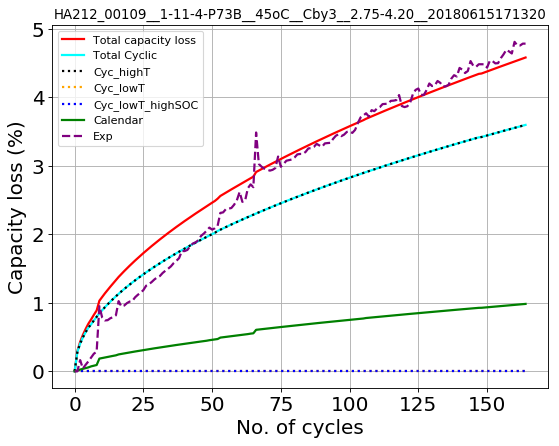

array([4.8094018 , 4.75703198, 4.75600816])

In [7]:
data_exp.head()

Cycle Index  Charge Capacity [Ah]  Charge Energy [mWh]  \
9            10             76.267770          287651.3806   
10           11             76.193645          287485.3195   
11           12             76.208096          287372.7562   
12           13             76.173337          287193.9524   
13           14             76.140084          287036.4292   

    Discharge Capacity [Ah]  Discharge Energy [mWh]  
9                 76.185109             279214.7355  
10                76.060593             278905.5454  
11                76.153549             279302.2193  
12                76.112430             279177.7325  
13                76.074542             279074.1242

In [11]:
Q_tot_percycle[-1]

4.580729423894732